In [1]:
# Notebook dependencies
import os
import sys
from IPython.display import display, Image

# **Project 1 - Search-based solutions for static Pac-Man game**
**Subject:** MC906/MO416 - Introduction to Artificial Intelligence 

**Authors:**

    Daniel Helú Prestes de Oliveira - RA 166215
    Eduardo Barros Innarelli        - RA 170161
    Victor Ferreira Ferrari         - RA 187890
    Vinícius Couto Espindola        - RA 188115

This group originally had 5 people, but one of them left the course near the due date for this project, so the final group has only 4 people, and the second informed method was divided between two of the leftover members: one handled the code, pre-analysis and introduction, and the other handled results, heuristics and final analysis.

## **Introduction**
### **Project**
  The project consists of a study of different search methods in goal-based solutions to a variation of the **Pac-Man** game. Five search methods were tested and will be discussed here, being:
- Two **uninformed** search methods (Breadth-First Search, Depth-First Search);
- Two **informed** search methods ($A^*$ Search, Greedy Best-First Search);
- One **local search** method (Simulated Annealing).

  Aside from the search methods, the modeling of the problem will also be discussed and tested, with characteristics such as:
- State representations (multiple);
- Set of actions;
- Objective state test;
- The path cost.

The models with different methods will be tested in different environments, and discussed accordingly.

### **Usage**
This project uses the _AIMA_ Python library for a generic implementation of the different search methods. You (the reader) can use any way you want to include that library in this notebook, but the following cell adds the library to the Python path if it is in the same folder as this notebook (if you clone the GitHub repository and its submodules, it should already be there).

In [2]:
direct = os.path.abspath('')
sys.path.insert(0,f'{direct}/aima-python')

Other external libraries used by the project are _NumPy_ for better array manipulation (maze), _Pandas_ for data organization in testing, _PyGame_ for visualization/animation of solutions and _wrapt_timeout_decorator_ for timeout in time-intensive methods. The other imports are part of the Standard Python Library.

The timeout decorator library and all other external libraries can be installed via _pip_. **The timeout decorator does not work in Windows.** This is due to the absence of signals in Windows, and specific ways in which it handles processes (when not using signals). This project uses signals for the timeout because in the multiprocess approach the results are not saved or displayed properly. Even without signals, the way in which the timeout had to be used in this project does not work in Windows: check [this link](https://github.com/bitranox/wrapt_timeout_decorator#use-with-windows) for more details.

In [3]:
# External Imports
import pandas as pd
import numpy as np
import pygame as py
from wrapt_timeout_decorator import timeout
from search import breadth_first_graph_search, depth_first_graph_search, astar_search, greedy_best_first_graph_search, simulated_annealing_full
from search import manhattan_distance, euclidean_distance, memoize, Problem

# Python libraries
import re, time
from itertools import product as combine
from random import choice

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# Configuration
np.set_printoptions(linewidth=150)

## **Problem**


### **Motivation and General Information**
Consider the Pac-Man video game. The problem at hand is a variation of the game. We're given a maze where each position can have one of the following: start (unique), goal (unique), enemy, dots, walls or empty spaces. The Pac-Man will begin the game in the start position and will try to reached the goal by only crossing through empty spaces and dots positions. In the event were Pac-Man reaches outside the map, it's position is "wrapped around" the map, meaning that it will appear on the oposite side of the map maintaining one of it's coodinates.
When compared to the original game, some simplifications were made: 
 - Ghosts do not move during the search (their initial position is their only position). 
 - Berries were removed from the game, therefore Pac-Man has no countermeasure against ghosts.

### **Details and Environment**
**Environment:** Is the maze described by the problem.

**Actuator:** The only action Pac-Man is allowed to execute is moving to a neighbor cell in the maze given the problems restrictions.

**Sensors:** We consider that Pac-Man can "see" the entirety of the given maze.

**Known:** The consquences to the environment given an action are completely predictable.

**Environment Properties:**
 - **Fully Observable:** We can see the entire maze at all times.
 - **Deterministic:** The next state is entirely defined by the current state and a possible action on it.
 - **Static:** The only change that occurs within the maze is caused by Pac-Man himself, the ghosts do not act.
 - **Discrete:** The environment has a finite number of states, being a finite maze with finite resources.
 - **Single Agent:** The only agent within the problem is Pac-Man.
 - **Sequential:** Every step builds on the previous ones to traverse the state space.


### **General Modeling Decisions**
  For every move Pac-Man takes, it will pay a **cost of 1 point**. However, if a dot is eaten, it will receive a **payment of 10 points**. The sum of all costs and payments will be considered the score achieved by Pac-Man when executing a certain path. The path cost is the opposite, so the relation is $score = -1 . pathcost$. Pac-Man can only move one position at a time, in the down, up, left and right directions. The nodes are expanded in that exact order. The goal has the same score/path cost than a dot, not being worth more for the score.
  
Based on the maze and general problem restrictions, we can seek the best feasible path for Pac-Man to reach the goal. In our case, "best" refers to the path in which we achieve the highest score. However, since goal-based agents are being used, the **primary goal** is to reach the final position. This distinction is important for some methods.

To save RAM, the maze is stored as **bytes** (ASCII characters), instead of unicode chars.

### **Different Models**
  For such a problem, there are many models that could be made to solve it, with potentially different state spaces, solutions and solution quality levels for each. Some could also be more appropriate for some methods than others. For that reason, it was decided that not one model would be the best for every situation, and the quality of the analysis would be better with **two** models being used with **every** method. The chosen models directly change the state space, and indirectly change what is the priority in achieving the goal.
  
  The first model has each state being a tuple representing **only** the position of Pac-Man in the maze. So, each position of the maze can only be visited **once** in graph-related searches (which almost all methods used are based on). This results in a **quadratic** state space, with $O(nm)$ states for a $n\times  m$ maze, which is good for the most high-complexity methods. This model also focuses more on **reaching the goal** than maximizing the score, since it does not consider paths that use the same position twice, in favor of eating more dots. This could waste a lot of potentially better results in the informed methods. The position control is made using a "global" maze as a class atribute in the problem.
  
  The second model has each state being a tuple with both the position of Pac-Man in the maze **and the current maze itself**. This model accepts the possiblity of visiting the same position in the maze twice **only if** the maze is different (a dot has been eaten somewhere since the last time). The state space is still finite, but **exponential**, so this could lead to very high memory usage and execution time in some methods. This model also lets the method decide the priority: maximizing the score or reaching the goal. Since the state includes the maze configuration, it can be used to try to maximize the score before heading to the goal by going through possibly the same position more than once. The maze in the state is stored as a **tuple of tuples**, since a state should be hashable and tuples are immutable.
  
  Other models were considered with less information about the maze inside a state, but for the scope of this project these two models were the ones used. In the "Conclusions" section, other alternatives are suggested for future work.

#### **Problem Model 1: State With Only the Coordintes**

In [5]:
# %load -r 30: PacProblemNoMaze.py
class Problem1(Problem):
    ''' Modeling the static Pac-Man game problem for search. '''
    
    def __init__(self, initial, goal, maze, heuristic = None):
        ''' Initial State:
            Tuple of 2 elements. (i,j) in maze.
            Goal State:
            Tuple of 2 elements. (i,j) in maze.
            Maze:
            NumPy array of BYTES (to save RAM)
        '''
        Problem.__init__(self, initial, goal)
        self.maze = maze
        self.heuristic = heuristic
        self.visited = set()
        self.explored = set()
        self.repeated_states = 0
        self.current = [None,0]
        
    def actions(self, state):
        ''' A state is the index of the maze (tuple). 
            An action is a tuple of i,j with the direction to walk.
        '''
        # Register new visited nodes
        hashing = state[0]*100+state[1]
        if hashing in self.visited: self.repeated_states += 1
        self.visited = self.visited.union([hashing])
        
        # Keep state and it's score for heuristic analisys
        self.current[0] = state
        self.current[1] += 1

        actions = []
        possible = [(1,0),(-1,0),(0,1),(0,-1)]
        idx = state

        # This is the new behavior of eating the points
        # Eat point if needed
        if self.maze[idx] == b'.':
            self.current[1] -= 9
            self.maze[idx] = b' '
        for action in possible:
            nxt = list(map(sum, zip(idx,action)))
            
            # Check circling around maze. If < 0, negative indexing will do the job.
            if nxt[0] == self.maze.shape[0]:
                nxt[0] = 0
            elif nxt[1] == self.maze.shape[1]:
                nxt[1] = 0
            nxt = tuple(nxt)
            
            # Check ghosts and walls.
            if self.maze[nxt] not in [b'o', b'|', b'-']:
                actions.append(action)
        
        # Register new explored nodes
        hashing = [(i+idx[0])*100 + (j+idx[1]) for i,j in actions]
        self.explored = self.explored.union(hashing)

        return actions

    def goal_test(self, state):
        ''' Check if the Pac-Man reaches its destination.'''
        return state == self.goal

    def result(self, state, action):
        ''' The result of an action is to move to the next position, and eat the point if needed.'''
        idx = state
        
        # Get next position.
        nxt = list(map(sum, zip(idx,action)))
        
        # Circle around maze.
        if nxt[0] == self.maze.shape[0]:
            nxt[0] = 0
        elif nxt[0] < 0:
            nxt[0] = self.maze.shape[0]-1
        elif nxt[1] == self.maze.shape[1]:
            nxt[1] = 0
        elif nxt[1] < 0:
            nxt[1] = self.maze.shape[1]-1
        
        nxt = tuple(nxt)

        return nxt
    
    def path_cost(self, c, state1, action, state2):
        ''' 10 points if it eats a point, and minus 1 point per movement. '''
        nxt = self.maze[state2]
        # Goal is same as a point (for now)
        if nxt == b'.' or nxt == b'?':
            cost = c-10
        else:
            cost = c
        return cost+1

    def value(self, state):
        ''' Value is the "score" for the state.'''
        # Use euclidean distance as a heuristic
        if self.heuristic == 'euclidean':
            return -5*euclidean_distance(state, self.goal)

        # Use manhatam distance as a heuristic
        if self.heuristic == 'manhattan':
            return -5*manhattan_distance(state, self.goal)

        # Use manhatam sum value as a heuristic
        if self.heuristic == 'pathcost':
            if state == self.current[0]:
                cost = self.current[1]
            elif self.maze[state] == b'.':
                cost = self.current[1] - 9
            else:
                cost = self.current[1] + 1
            return -1*cost

        # Error if no heuristic defined
        if not self.heuristic:
            raise Exception("CHOOSE A HEURISTIC before executing")
        if callable(self.heuristic):
            raise Exception("CHOOSE A HEURISTIC NAME before executing, not a function.")
        
    def h(self, node):
        ''' Heuristic for informed/local search methods '''
        
        assert self.heuristic != None, "Heuristic must be set!"
        assert callable(self.heuristic), "Heuristic must be a function!"
        
        # Need to receive maze to estimate
        return self.heuristic(node, self.maze)

#### **Problem Model 2: State With Coordinates and Maze**

In [6]:
# %load -r 29: PacProblem.py
class Problem2(Problem):
    ''' Modeling the static Pac-Man game problem for search. '''
    
    def __init__(self, initial, goal, heuristic = None):
        ''' Initial State:
            Tuple of 2 elements. 1-Initial maze. 2. (i,j) in maze.
            Goal State:
            Tuple of 2 elements. (i,j) in maze.
        '''
        Problem.__init__(self, initial, goal)
        self.visited = set()
        self.explored = set()
        self.repeated_states = 0
        self.counter = 0
        self.heuristic = heuristic
        
    def actions(self, state):
        ''' 
            A state is the current maze (tuple of tuples) and the agent index
            in the maze (tuple). An action is a tuple of i,j with the direction 
            to walk.
        '''
        self.visited = self.visited.union([self.counter])

        actions = []
        possible = [(1,0),(-1,0),(0,1),(0,-1)]
        tuple_maze, idx = state
                
        # Convert maze into a numpy array.
        maze = np.array(tuple_maze)
        
        for action in possible:
            nxt = list(map(sum, zip(idx,action)))
                        
            # Check circling around maze. If < 0, negative indexing will do the job.
            if nxt[0] == maze.shape[0]:
                nxt[0] = 0
            elif nxt[0] < 0:
                nxt[0] = maze.shape[0]-1
            elif nxt[1] == maze.shape[1]:
                nxt[1] = 0
            elif nxt[1] < 0:
                nxt[1] = maze.shape[1] - 1
                
            nxt = tuple(nxt)
            
            # Check ghosts and walls.
            if maze[nxt] not in [b'o', b'|', b'-']:
                actions.append(action)
        
        self.explored = self.explored.union(range(self.counter,self.counter+4))
        self.counter += 4
        return actions

    def goal_test(self, state):
        ''' Check if the Pac-Man reaches its destination.'''
        return state[1] == self.goal

    def result(self, state, action):
        ''' The result of an action is to move to the next position, and eat the point if needed.'''
        tuple_maze, idx = state
        
        # Convert maze into a numpy array.         
        maze = np.array(tuple_maze)
        
        # Get next position.
        nxt = list(map(sum, zip(idx,action)))
        
        # Circle around maze.
        if nxt[0] == maze.shape[0]:
            nxt[0] = 0
        elif nxt[0] < 0:
            nxt[0] = maze.shape[0]-1
        elif nxt[1] == maze.shape[1]:
            nxt[1] = 0
        elif nxt[1] < 0:
            nxt[1] = maze.shape[1]-1
        
        nxt = tuple(nxt)
        
        # Eat point if needed
        if maze[nxt] == b'.':
            maze[nxt] = b' '
        return tuple(map(tuple, maze)), nxt
    
    def path_cost(self, c, state1, action, state2):
        ''' 10 points if it eats a point, and minus 1 point per movement. '''
        nxt = np.array(state1[0])[state2[1]]
        
        # Goal is same as a point (for now)
        if nxt == b'.' or nxt == b'?':
            cost = c-10
        else:
            cost = c
        return cost+1

    def value(self, state):
        ''' Value is the "score" for the state.'''
        return -1 * self.path_cost(None, None, None, state)
    
    def h(self, node):
        ''' Heuristic for informed/local search methods '''
        
        assert self.heuristic != None, "Heuristic must be set!"
        
        # No need to receive maze to estimate, as it is stored in node.state
        return self.heuristic(node)

## **Solution Visualization**
In order to create a nice way to visualize each search behaviours, we used PyGame library visual interface to draw the maze with the Pac-Man's path. This was achieved by transforming the matrix with the maze in a matrix which mapped the display pixels. For the creation and manipulation of such, we defined a class PacScreen which serves as an interface between the search agent and the screen.

To create the pixels map we simply represent each position of the matrix with a offset defined as `px=28` in PacScreen. This allows us to have a `px` square block to draw the contents of each position. To reference the block, we simply use the matrix indexes of the position we want to draw and multiply then by `px`, this gives us the top-left vertex of the corresponding block. However, since matrices are indexed as `M[i,j]`, where `i` is the line and `j` the column, and the display is indexed with cartesian coordinates `(x,y)`, we must map the indexes `i` and `j` to `y` and `x`, respectively.

The PacScreen class works through the following steps: 
 * First we initialize the class by setting essential parameters such as: a copy of the maze to be used as reference, the size of the screen (considering how many pixels each block will hold), the Pacman's initial position and the goal position.
 * Once we've ran a search with the same maze in PacScreen, we create a sequence of indexes `(i,j)` which indicate the Pac-Man's path in the maze. This sequence is then passed to the `PacScreen.run()` function were the maze is drawn in each of the positions visited by Pac-Man.
 * Inside the `run()` function, we fist draw the starting environment with `PacScreen.draw()`. Then, every `interval=0.005` seconds we update the display with the next position using `PacScreen.update()`. The `update()` function is a light weight version of `draw()` where we only update what is necessary.
 
**Note:** PyGame provides funcions which allows us to draw circles, rectangle and polygons, these were used to represent the map contained in the matrix. The walls are blocks filled with blue rectangles, the ghosts are triangles, the goal is a red circle, the dots are white circles and Pac-Man is represented by the yellow circle.


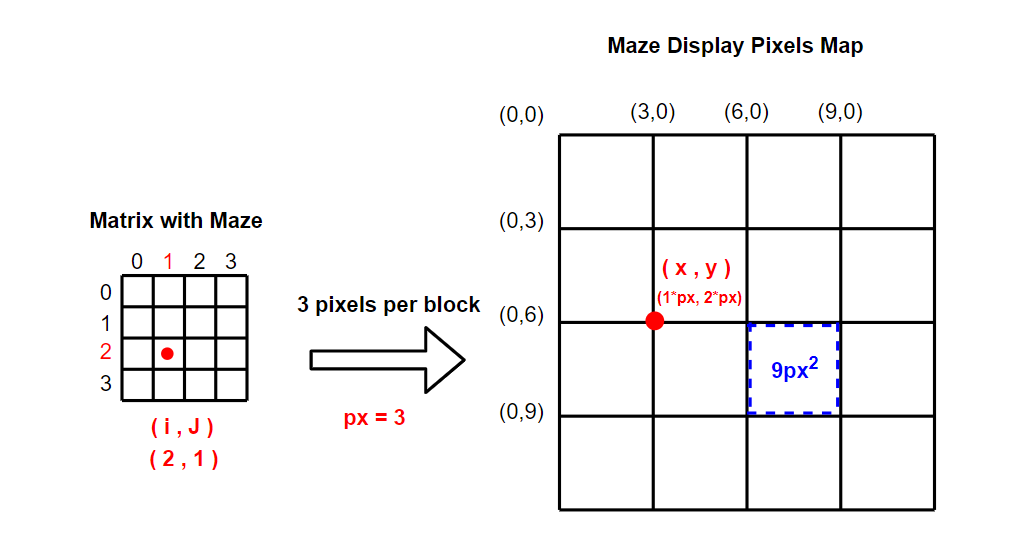

In [8]:
Image(filename='images/display_transform.png') 

In [7]:
# %load -r 26:125 PacScreen.py

black = (0,0,0)
grey = (50,50,50)
white = (255,255,255)
red = (255,0,0)
green = (0,255,0)
blue = (0,0,200)
yellow = (255,255,0)

# Múltiple of 4 ples
px = 28

class PacScreen():

    def __init__(self, maze):
        self.maze = maze.copy()
        self.size = (self.maze.shape[1]*px,self.maze.shape[0]*px)

        self.pac = tuple(map(int, np.where(self.maze==b'!')))
        self.goal = tuple(map(int, np.where(self.maze==b'?'))) 

    def draw(self, maze, pac, goal):
        walls = (maze==b'|')
        bars = (maze==b'-')
        dots = (maze==b'.')
        ghosts = (maze==b'o')
        y_max,x_max = maze.shape

        for i in range(y_max):
            for j in range(x_max):
                x = j*px
                y = i*px
                if walls[i][j]:
                    py.draw.rect(self.disp, blue, (x,y,px,px))
                if bars[i][j]:
                    py.draw.rect(self.disp, white, (x,int(y+px/2-px/4),px,int(px/4)))
                if dots[i][j]:
                    x_c = int(x+px/2)
                    y_c = int(y+px/2)
                    rad = int(px/5)
                    py.draw.circle(self.disp, white, (x_c,y_c), rad)
                if ghosts[i][j]:
                    a = (x,y+px)
                    b = (x+px,y+px)
                    c = (int(x+px/2),y)
                    py.draw.polygon(self.disp, green, (a,b,c))
        
        x_c = int(pac[1]*px + px/2)
        y_c = int(pac[0]*px + px/2)
        rad = int(px/3)
        py.draw.circle(self.disp, yellow, (x_c,y_c), rad)

        x_c = int(goal[1]*px + px/2)
        y_c = int(goal[0]*px + px/2)
        rad = int(px/4)
        py.draw.circle(self.disp, red, (x_c,y_c), rad)

    def update(self, maze, pac):
        # Erase old pacman
        x = self.pac[1]*px
        y = self.pac[0]*px
        py.draw.rect(self.disp, black, (x,y,px,px))
        
        # Leave visited tag
        x_c = int(self.pac[1]*px + px/2)
        y_c = int(self.pac[0]*px + px/2)
        rad = int(px/4)
        py.draw.circle(self.disp, grey, (x_c,y_c), rad)

        # Update and draw
        self.pac = pac
        x_c = int(self.pac[1]*px + px/2)
        y_c = int(self.pac[0]*px + px/2)
        rad = int(px/3)
        py.draw.circle(self.disp, yellow, (x_c,y_c), rad)

    def step(self, action):    
        if self.maze[action] == b'.':
            self.maze[action] = ' ' 
        self.update(self.maze, action)

    def run(self, path, interval=0.005):
        # Create window and draw
        self.disp = py.display.set_mode(self.size)
        self.disp.fill(black)
        self.map = py.PixelArray(self.disp)
        self.draw(self.maze, self.pac, self.goal)

        # Animate
        while True:
            for event in py.event.get():
                if event.type == py.QUIT:
                    py.quit()
                    return

            if path:
                self.step(path.pop(0))
                py.display.update()
            time.sleep(interval)

 ## **Search Agent**

### **Motivation**
This project consists of different search solutions for the same few problem models, and most methods use the same data structures. In that sense, the logical step to take is to create a shared API for every method, so that the environment is the same for every method, standardizing testing and result analysis. This agent should be able to formulate any of the problem models, change problem variables/properties and provide an API for result analysis.


### **API**
The SearchAgent class can be seen in the cell bellow:

In [9]:
# %load -r 26: SearchAgent.py
class SearchAgent:
    def __init__(self, maze):
        self.maze = maze
        self.display = None
        self.problem = None
        self.solution = None
        self.init = None
        self.state_maze = False
        self.heuristic = None
    
    def set_maze(self, maze):
        self.maze = maze
        if self.problem and not self.state_maze:
            self.problem.maze = maze.copy()
            
    def set_heuristic(self, heuristic):
        self.heuristic = heuristic
        if self.problem:
            self.problem.heuristic = heuristic

    def find_positions(self):
        ''' Find initial and goal positions in correctly made mazes.'''
        init = np.where(self.maze == b'!')
        goal = np.where(self.maze == b'?')

        # If init is not defined.
        if init[0].size == 0:
            init = None
        else:
            init = init[0][0], init[1][0]
        
        # If goal is not defined.
        if goal[0].size == 0:
            goal = None
        else:
            goal = goal[0][0], goal[1][0]
        return init, goal
    
    def formulate_problem(self, initial_pos, goal_pos, with_maze, goal_conditions):
        ''' Formulates problem based on positions and if maze is in state or not.'''
        self.init = initial_pos        
        
        # Conditions
        assert all(self.maze[initial_pos] != t for t in goal_conditions), "Initial position does not satisfy conditions!"
        assert all(self.maze[goal_pos] != t for t in goal_conditions), "Goal does not satisfy conditions!"
    
        if not with_maze:
            # Problem with maze in state
            self.problem = Problem1(initial_pos, goal_pos, self.maze.copy(), self.heuristic)
        else:
            # Problem with only Pac-Man position in state
            initial_pos = (tuple(map(tuple, self.maze)), initial_pos)
            self.problem = Problem2(initial_pos, goal_pos, self.heuristic)
        
        self.state_maze = with_maze
    
    def search(self, method, *args):
        ''' Execute search (solve problem). '''
        self.solution = method(self.problem, *args)
    
    def get_solution(self):
        if isinstance(self.solution, tuple):
            return self.solution
        elif self.solution:
            return self.solution.solution()
        else:
            return []
    
    def get_path(self):
        if self.solution:
            return self.solution.path()
        else:
            return []
            
    def get_score(self):
        if self.solution:
            return -1*self.solution.path_cost
        else:
            return 0
    
    def get_explored(self):
        if self.problem:
            return len(self.problem.explored)
        else: 
            return 0

    def get_visited(self):
        if self.problem:
            return len(self.problem.visited)
        else: 
            return 0

    def get_repeated(self):
        if self.problem:
            return self.problem.repeated_states
        else: 
            return 0


    def transform_path(self):
        ''' Transforms a path of nodes to a path of positions. '''
        pos = []
        path = self.solution.path()
        
        # Transform to positions            
        # If maze is in state
        if self.state_maze:
            for node in path:
                pos.append(node.state[1])
        else:
            for node in path:
                pos.append(node.state)
        return pos
    
    def display_path(self, path, interval=0.005):
        ''' Animate maze, to visualize found path. '''
        self.display = PacScreen(self.maze)
        self.display.run(path, interval)
    
    def apply_actions(self, actions):
        ''' Apply actions to maze in ascii, to visualize found path. '''
        direct_x = {1:b'>', -1:b'<'}
        direct_y = {-1:b'^', 1:b'v'}
        directions = {b'^', b'v', b'<', b'>'}
        maze = self.maze.copy()
        pos = self.init
        
        # Initial
        maze[pos] = b'!'
        for act in actions:
            pos = list(map(sum, zip(pos,act)))
            
            # Circle around maze
            if pos[0] == maze.shape[0]:
                pos[0] = 0
            elif pos[0] < 0:
                pos[0] = maze.shape[0]-1
            elif pos[1] == maze.shape[1]:
                pos[1] = 0
            elif pos[1] < 0:
                pos[1] = maze.shape[1]-1
            pos = tuple(pos)
            
            if maze[pos] in directions:
                continue
            
            if act[0] != 0:
                maze[pos] = direct_y[act[0]]
            elif act[1] != 0:      
                maze[pos] = direct_x[act[1]]
        
        # Goal
        maze[pos] = b'?'
        return maze


The SearchAgent lets the user:
- Find the initial and goal positions of a maze from a standard as seen in the next section;
- Formulate any of the problem models, given an initial position, a goal position, goal conditions and flags indicating the model to use;
- Change the maze without changing the problem;
- Formulate a new problem with the same maze;
- Use any search method from AIMA and store its return object;
- Get the solution (sequence of actions or path);
- Get the solution path;
- Get the total ammount of node visited by the search;
- Get the final score from the solution;
- Visualize the solution in ASCII form, returning a NumPy array with the maze modified with the taken path;
- Use an animation engine created in _pygame_ to animate the final path.

Therefore, it accomplishes its objective of providing a generic environment to run tests and solve the problem. 

In [10]:
agent = SearchAgent(None)

## **Test Cases**

For testing purposes, we generated 10 mazes using the [tool provided by classmate Gabriel Bomfim](https://gabomfim.github.io/pacman-mazegen/tetris/many.htm) in Google Classroom, which adapts the [maze generator](https://shaunlebron.github.io/pacman-mazegen/) linked in the project description. Each tile is represented by a char, where **|** and **-** are walls, **.** are foods and **o** are ghosts. For each maze, we choosed three start and goal positions, respectively symbolized by **!** and **?**.

As this tool creates mazes filled with food, we thought that it would be good for comparison to also test sparse mazes, which we created by randomly removing dots in the dense ones. These variations, together with the originals, give us a total of 60 mazes, stored in `./mazes` directory.

The tests were run with the SearchAgent class defined in the previous section.

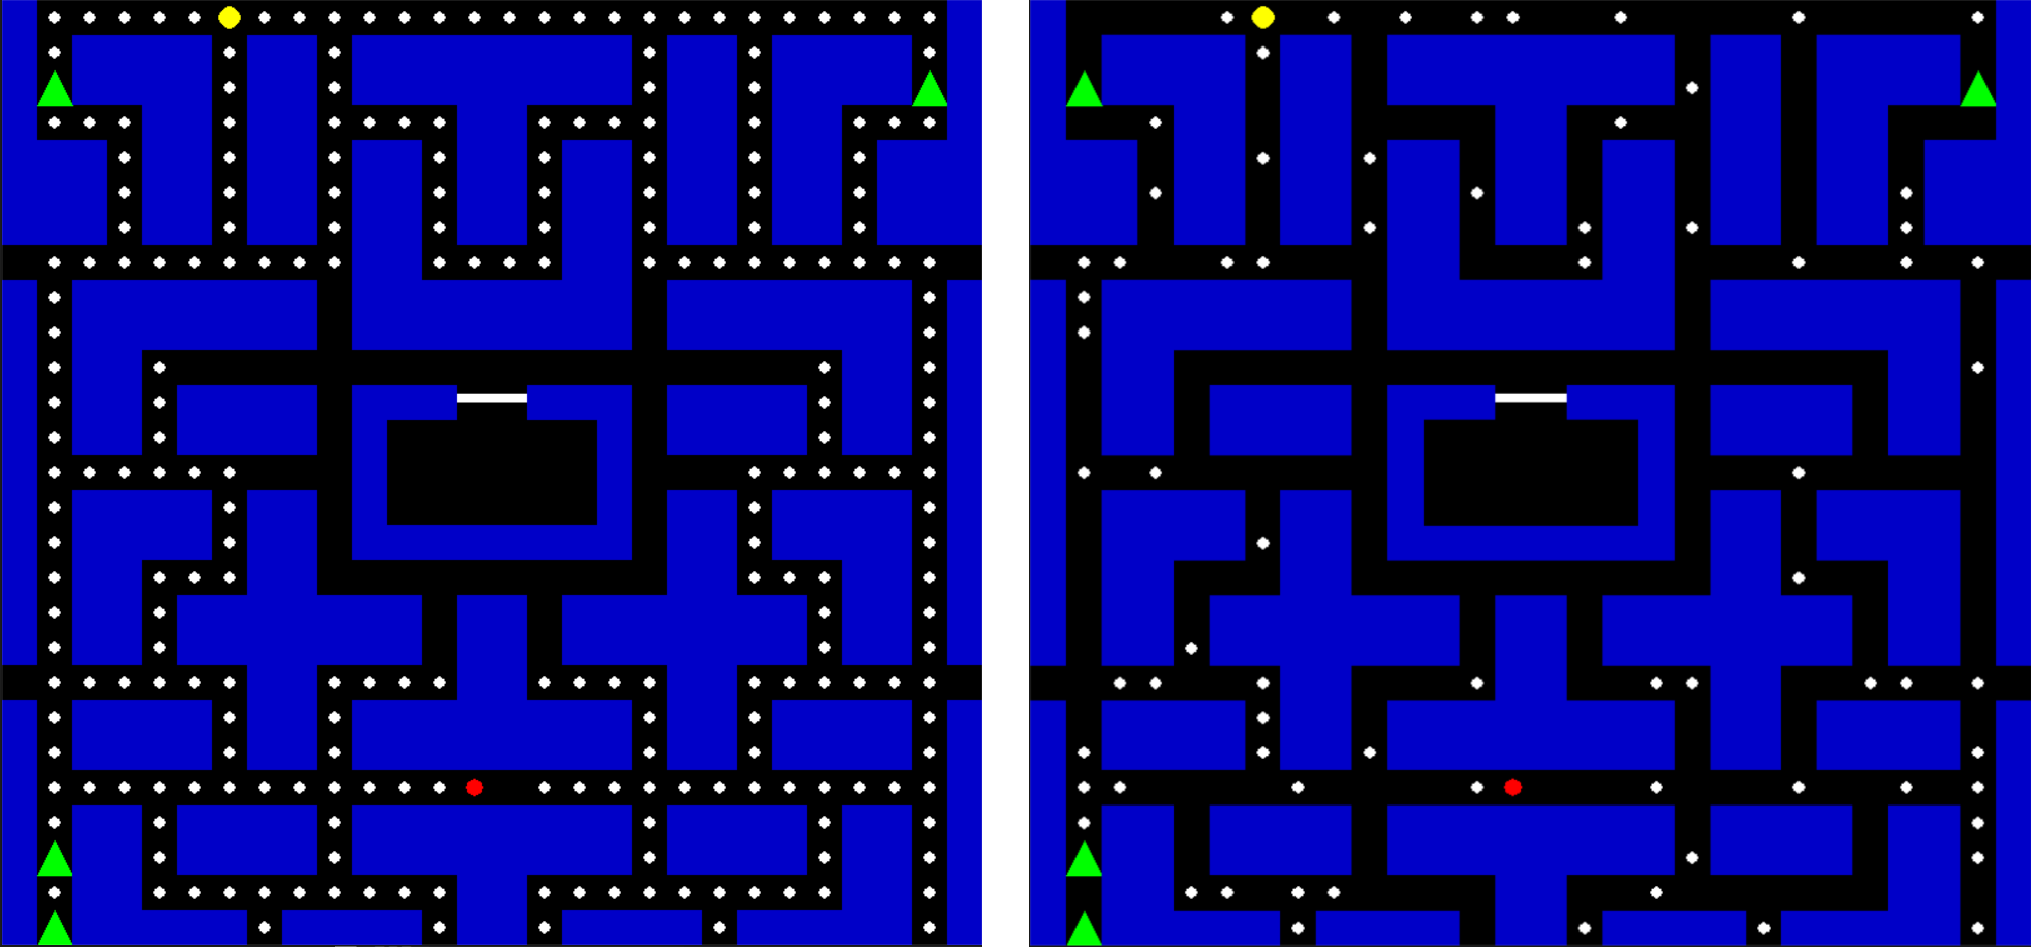

In [11]:
Image(filename='images/test_sample.png') 

In [12]:
# %load -r 7:13 testing.py
# Getting test files
path = 'mazes/'
sizes = ['dense/','sparse/']
maze = ['1','2','3','4','5','6','7','8','9','10']
pos = ['a','b','c']
test_files = [path+s+i+l for (s,i,l) in list(combine(sizes,maze,pos))]

In [13]:
# %load -r 14:120 testing.py
def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + ' ' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()  # As suggested by Rom Ruben (see: http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console/27871113#comment50529068_27871113)

def collect_data(data, out_path):
    # Gather info by grouping dense/sparse and map
    ids = data.groupby(['type','id'])
    ids_means = ids.mean()
    ids_means.name = 'ids_means'
    ids_max = ids.max().drop(columns='class')
    ids_max.name = 'ids_max'
    ids_min = ids.min().drop(columns='class')
    ids_min.name = 'ids_min'

    # Gather info by grouping dense/sparse
    types = data.groupby(['type'])
    types_means = types.mean()
    types_means.name = 'types_mean'
    types_max = types.max().drop(columns='class')
    types_max.name = 'types_max'
    types_min = types.min().drop(columns='class')
    types_min.name = 'types_min'

    dataframes = [data,ids_means,ids_max,ids_min,types_means,types_max,types_min,]
    if out_path:
        for df in dataframes: df.to_csv(f'{out_path}/{df.name}.csv')
                        
    return dataframes
    
#### TESTING ROUTINE ####

def run_tests(test_files, search, *args, repeat=1, out_path=''):
    print("#### Starting New Test Routine ####")
    keys = ['type','id','class',f'time_{repeat}avg',f'score_{repeat}avg',f'fails_{repeat}total','visited','repeated','explored']
    data = pd.DataFrame(columns=keys)
    data.name='all_data'
    count,total = 0, repeat*len(test_files)
    agent = None

    for maze_file in test_files: 
        maze = np.genfromtxt(maze_file, dtype=str, delimiter=1).astype('bytes')
        if not agent: agent = SearchAgent(maze) # Build agent if not yet created
        
        deltas = []
        fails = []
        costs = []
        visits = []
        repeated = []
        explored = []

        for i in range(1,repeat+1):
            count += 1
            progress(count, total, status=f"{maze_file} X{i:4d}")            
            
            # Set up new map
            agent.set_maze(maze)                # Reset agent's maze
            init,goal = agent.find_positions()  # Reset positions

            # Run and time it
            t0 = time.perf_counter()
            try:
                cost = search(agent, maze, init, goal, *args)
            except TimeoutError:
                cost = 0
            finally:
                tf = time.perf_counter()

            # Data acumulators
            deltas += [tf - t0]
            fails += [0 if cost else 1]
            costs += [0 if not cost else cost]
            visits += [agent.get_visited()]
            repeated += [agent.get_repeated()]
            explored += [agent.get_explored()]

        fails_ratio = sum(fails)/repeat
        deltas_avg = sum(deltas)/repeat # Consider failures
        if fails_ratio < 1:
            score_avg = sum(costs)/(repeat-sum(fails)) # Don't consider failures
        else:
            score_avg = 0
        visits_avg = sum(visits)/repeat
        repeated_avg = sum(repeated)/repeat
        explored_avg = sum(explored)/repeat

        # Fetch info from file name
        match = re.match(r'mazes/(\w+)/(\d+)(\w)', maze_file)
        maze_type = match.group(1)
        maze_id = int(match.group(2))
        maze_class = match.group(3)

        # Add results to dataframe
        values = [maze_type,maze_id,maze_class,deltas_avg,score_avg,
                  fails_ratio,visits_avg,repeated_avg,explored_avg]
        data.loc[maze_file] = dict(zip(keys, values))
    print("\n")

    # print(data)

    return collect_data(data, out_path)

## **Uninformed Search Methods**
The Uninformed Search Methods, also known as Blind Search Methods, are algorithms that are given no information about the problem other than its definition. They are only able to generate possible successors of a state and analyze these sucessors in a sequence according to the algorithm applied. They analyze each successor created until it finds the goal state. Every state receives the same treatment, and every decision is local according to a method that can only use local information of the problem (if any).

### **Breadth-First Search (BFS) Solution**
###### **Responsible:** Victor

#### **The Method**
Breadth-First Search (BFS) is an Uninformed Search method that visits every state in order of distance from the initial state. So this method expands every successor once it reaches a node, and then visits each one of them in a predetermined order in a queue (FIFO). In the _AIMA_ library, this is done in the order of actions given by the problem.

BFS, for the Pac-Man problem, is a complete method, since the maze is finite and in the **graph** variation the method does not visit the same state twice. The graph variation is used because there can be loops in the state space, so a tree is not the best representation of it. This method always gets the shortest path to the goal position, but it is **not** an optimal method for the problem, because not all paths have the same cost, eating more dots will result in better solutions.

This method is **exact and deterministic**, so it will **always** return the same solution to an instance. For that reason, there's no use in averaging results from different executions, and the method can be analyzed with only one execution.

#### **Pre-Analysis**
Since this method always expands the shallowest node, memory and time can be a big problem, so problems with less successors in each node and/or shallower trees can make a huge difference in these constraints. For that reason, between the two models created for the problem, the one that does not have the maze in its state is the likely best one for this method. 

Since BFS always finds the shortest path to the goal and always visits the shallowest node available, it will never need to check the same position twice. It will go through every position in the maze in order of proximity to the initial point, eventually getting to the goal without needing to cross a taken path. So the quadratic state space of the model with only the position as state will likely get the same answer as the exponential state space of the other model, but faster.

And this increase in speed (and memory usage) can be pivotal, for this method can easily explode in time and memory with the more complex model. However, this likely behavior also hints that the result will not include a very high score, because the path cost is not considered at all in this method.

#### **Results for Model Without Maze in State**

In [14]:
def bfs_no_maze(agent, maze, init, goal, *args):
    agent.formulate_problem(init, goal, False, [b'-', b'|', b'o', b'_'])
    agent.search(breadth_first_graph_search)
    return agent.get_score()

# Run all tests
dataframes = run_tests(
    test_files, 
    bfs_no_maze, 
    [], 
    repeat=1, 
    out_path='data/bfs/problem1'
)

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

#### Starting New Test Routine ####
[============================================================] 100.0% ...mazes/sparse/10c X   1

================ all_data ================



,type,id,class,time_1avg,score_1avg,fails_1total,visited,repeated,explored
mazes/dense/1a,dense,1,a,0.011206,108.0,0.0,71.0,0.0,86.0
mazes/dense/1b,dense,1,b,0.016305,-5.0,0.0,105.0,0.0,119.0
mazes/dense/1c,dense,1,c,0.025395,105.0,0.0,225.0,0.0,256.0
mazes/dense/2a,dense,2,a,0.026213,105.0,0.0,241.0,0.0,258.0
mazes/dense/2b,dense,2,b,0.021031,215.0,0.0,205.0,0.0,224.0
mazes/dense/2c,dense,2,c,0.012980,111.0,0.0,145.0,0.0,167.0
mazes/dense/3a,dense,3,a,0.005655,-3.0,0.0,57.0,0.0,66.0
mazes/dense/3b,dense,3,b,0.009212,135.0,0.0,93.0,0.0,121.0
mazes/dense/3c,dense,3,c,0.014097,135.0,0.0,114.0,0.0,145.0
mazes/dense/4a,dense,4,a,0.023966,217.0,0.0,261.0,0.0,280.0


================ ids_means ================



time_1avg  score_1avg  fails_1total     visited  repeated  \
type   id                                                              
dense  1    0.017635   69.333333           0.0  133.666667       0.0   
       2    0.020075  143.666667           0.0  197.000000       0.0   
       3    0.009655   89.000000           0.0   88.000000       0.0   
       4    0.013339  164.000000           0.0  136.333333       0.0   
       5    0.014197  138.000000           0.0  138.000000       0.0   
       6    0.025657  150.333333           0.0  227.000000       0.0   
       7    0.016995  172.000000           0.0  165.666667       0.0   
       8    0.017580  124.000000           0.0  143.666667       0.0   
       9    0.017131  164.333333           0.0  151.333333       0.0   
       10   0.020653  107.333333           0.0  183.333333       0.0   
sparse 1    0.017942   19.333333           0.0  133.666667       0.0   
       2    0.025832   30.333333           0.0  197.000000       0.0   
       3    0.010581   19.000000           0.0   88.000000       0.0   
       4    0.014039   30.666667           0.0  136.333333       0.0   
       5    0.013609   31.333333           0.0  138.000000       0.0   
       6    0.025557   13.666667           0.0  227.000000       0.0   
       7    0.018311   48.666667           0.0  165.666667       0.0   
       8    0.015270   20.666667           0.0  143.666667       0.0   
       9    0.015725   37.666667           0.0  151.333333       0.0   
       10   0.018918   14.000000           0.0  183.333333       0.0   

             explored  
type   id              
dense  1   153.666667  
       2   216.333333  
       3   110.666667  
       4   153.333333  
       5   149.333333  
       6   252.000000  
       7   182.000000  
       8   165.666667  
       9   176.000000  
       10  208.000000  
sparse 1   153.666667  
       2   216.333333  
       3   110.666667  
       4   153.333333  
       5   149.333333  
       6   252.000000  
       7   182.000000  
       8   165.666667  
       9   176.000000  
       10  208.000000

================ ids_max ================



time_1avg  score_1avg  fails_1total  visited  repeated  explored
type   id                                                                  
dense  1    0.025395       108.0           0.0    225.0       0.0     256.0
       2    0.026213       215.0           0.0    241.0       0.0     258.0
       3    0.014097       135.0           0.0    114.0       0.0     145.0
       4    0.023966       217.0           0.0    261.0       0.0     280.0
       5    0.029688       270.0           0.0    286.0       0.0     301.0
       6    0.030419       162.0           0.0    276.0       0.0     297.0
       7    0.027521       241.0           0.0    259.0       0.0     275.0
       8    0.027580       198.0           0.0    214.0       0.0     240.0
       9    0.025571       216.0           0.0    227.0       0.0     255.0
       10   0.027504       182.0           0.0    235.0       0.0     261.0
sparse 1    0.028682        38.0           0.0    225.0       0.0     256.0
       2    0.037563        55.0           0.0    241.0       0.0     258.0
       3    0.013781        45.0           0.0    114.0       0.0     145.0
       4    0.026561        47.0           0.0    261.0       0.0     280.0
       5    0.030076        70.0           0.0    286.0       0.0     301.0
       6    0.030856        22.0           0.0    276.0       0.0     297.0
       7    0.027837        91.0           0.0    259.0       0.0     275.0
       8    0.022418        38.0           0.0    214.0       0.0     240.0
       9    0.022869        43.0           0.0    227.0       0.0     255.0
       10   0.024423        32.0           0.0    235.0       0.0     261.0

================ ids_min ================



time_1avg  score_1avg  fails_1total  visited  repeated  explored
type   id                                                                  
dense  1    0.011206        -5.0           0.0     71.0       0.0      86.0
       2    0.012980       105.0           0.0    145.0       0.0     167.0
       3    0.005655        -3.0           0.0     57.0       0.0      66.0
       4    0.007826       113.0           0.0     71.0       0.0      89.0
       5    0.002881         1.0           0.0     30.0       0.0      37.0
       6    0.017285       136.0           0.0    152.0       0.0     179.0
       7    0.011565       123.0           0.0    114.0       0.0     130.0
       8    0.002566         3.0           0.0     27.0       0.0      35.0
       9    0.005042        94.0           0.0     51.0       0.0      65.0
       10   0.015942        49.0           0.0    156.0       0.0     176.0
sparse 1    0.012275        -5.0           0.0     71.0       0.0      86.0
       2    0.015501         1.0           0.0    145.0       0.0     167.0
       3    0.006046        -3.0           0.0     57.0       0.0      66.0
       4    0.007632        13.0           0.0     71.0       0.0      89.0
       5    0.002459         1.0           0.0     30.0       0.0      37.0
       6    0.017879         3.0           0.0    152.0       0.0     179.0
       7    0.013525        22.0           0.0    114.0       0.0     130.0
       8    0.002532         3.0           0.0     27.0       0.0      35.0
       9    0.005519        34.0           0.0     51.0       0.0      65.0
       10   0.015901        -1.0           0.0    156.0       0.0     176.0

================ types_mean ================



,time_1avg,score_1avg,fails_1total,visited,repeated,explored
type,,,,,,
dense,0.017292,132.200000,0.0,156.4,0.0,176.7
sparse,0.017578,26.533333,0.0,156.4,0.0,176.7


================ types_max ================



,id,time_1avg,score_1avg,fails_1total,visited,repeated,explored
type,,,,,,,
dense,10,0.030419,270.0,0.0,286.0,0.0,301.0
sparse,10,0.037563,91.0,0.0,286.0,0.0,301.0


================ types_min ================



,id,time_1avg,score_1avg,fails_1total,visited,repeated,explored
type,,,,,,,
dense,1,0.002566,-5.0,0.0,27.0,0.0,35.0
sparse,1,0.002459,-5.0,0.0,27.0,0.0,35.0


#### **Results for Model With Maze in State**

CAUTION: the below cell can take a really long time to run, and use a lot of RAM if timeout is too slow or not working. Timeout **does not work on Windows**, so if that's the used operating system, take out/comment that line, and be careful with RAM.

In [ ]:
@timeout(60, use_signals=True)
def bfs_with_maze(agent, maze, init, goal, *args):
    agent.formulate_problem(init, goal, True, [b'-', b'|', b'o', b'_'])
    agent.search(breadth_first_graph_search)
    return agent.get_score()

# Run all tests
dataframes = run_tests(
    test_files, 
    bfs_with_maze, 
    [], 
    repeat=1, 
    out_path='data/bfs/problem2'
)

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

#### **Analysis**
As discussed in the pre-analysis, the diference in time requirements between both models is very high, for the exact same answers. This is a specific characteristic of BFS, since it always takes the shortest route, and it never crosses the same position twice. It was not possible to run every maze with BFS in the second model, because the execution time "explodes", as does the memory usage, so the execution fails after a timeout.

The Pac-Man scores result for this method are not consistent, since BFS does not have any mechanisms to try and optimize the score, they are a byproduct of the shortest path found. There are instances where another direct path with the same length would result in a better score, as can be seen in an animation by running the cells below. Negative scores are usually the result of direct paths without dots to the goal. Except in those situations, the method had better scores in dense mazes with a far goal because the found path was more likely to have more dots.

The second model, by allowing to go through positions again every time a dot is eaten, is a lot slower, but there is a noticeable difference between the results for the dense and sparse variations of the test mazes. A higher percentage of dense mazes timed out compared to sparse mazes. This happens because sparse mazes, by having fewer dots, also "reset" the positions fewer times, and so the state space is smaller and goal can be reached more quickly. The amount of visited and explored nodes reflect this behavior.

Analysing just the behavior of this method, isolated, it is clear that the model **without the maze in the states** is the superior choice, with the same result but up to thousands of times faster and exploring/visiting fewer nodes.

In [ ]:
maze = np.genfromtxt('mazes/dense/2a', dtype=str, delimiter=1).astype('bytes')
agent.set_maze(maze)
init, goal = agent.find_positions()
agent.formulate_problem(init, goal, False, [b'-', b'|', b'o', b'_'])
agent.search(breadth_first_graph_search)

In [ ]:
path = agent.transform_path()
agent.display_path(path, 0.3)

#### **Random Maze Animation**
Running the cells below, a random maze can be solved with BFS and the first model (since it is better). An animation will run showcasing the solution (in a new window) and an ASCII representation of the solution will also be available.

In [ ]:
maze_file = choice(test_files)
maze = np.genfromtxt(maze_file, dtype=str, delimiter=1).astype('bytes')
agent.set_maze(maze)
init, goal = agent.find_positions()
agent.formulate_problem(init, goal, False, [b'-', b'|', b'o', b'_'])
agent.search(breadth_first_graph_search)
sol = agent.apply_actions(agent.get_solution())
print(sol.astype('<U1'))
print("Score: ", agent.get_score())

In [ ]:
path = agent.transform_path()
agent.display_path(path, 0.3)

### **Depth-First Search Solution**
###### **Responsible:** Daniel

#### **The Method**
The Depth-First Search(DFS) is an Uninformed Search method that expands its deepest node possible first, the one that has no sucessor. If the node is the goal state, it has found the path to the solution, otherwise it goes back to the most recent ancestor node that still has successor that were not expanded and it expands the deepest sucessor this ancestor node has.

For the Pacman Problem the goal state considered for the problem was the final position that pacman should go. It did not consider analyzing all the possible outcomes of eating the dots to increase it points because the time and memory to consider all possible states would be exponential.

The choosen search method between the two possible types of DFS inside the library was the **depth_first_graph_search**. The **depth_first_tree_search** implementation does not prevent a loop state as the pacman can return to the same position if its reach a dead end. The **depth_first_graph_search**, on the otherhand, avoids repeated states and redundant paths which can solve the problem of pacman getting caught in a loop.

#### **Results of the DFS using only the indexes as state**

As first approach, we used only the position of the Pacman as part of the state of the problem. After running the code we can see the tables to view the time it took to calculate the solution for each maze and the number of points Pacman scored.

In [ ]:
def dfs_no_maze(agent, maze, init, goal, *args):
    ''' triggers DFS method and returns the score '''
    agent.formulate_problem(init, goal, False, [b'-', b'|', b'o', b'_'])
    agent.search(depth_first_graph_search)
    return agent.get_score()

# Run all tests
dataframes = run_tests(
    test_files, 
    dfs_no_maze, 
    [], 
    repeat=1, 
    out_path='data/dfs/nomaze'
)

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

#### **Results of the DFS using the map and indexes as state**

In the second approach we also considered the maze including its dots as part of the state. After running the code we can see the tables to view the time it took to calculate the solution for each maze and the number of points Pacman scored.

In [ ]:
def dfs_with_maze(agent, maze, init, goal, *args):
    ''' triggers DFS and returns the score '''
    agent.formulate_problem(init, goal, True, [b'-', b'|', b'o', b'_'])
    agent.search(depth_first_graph_search)
    return agent.get_score()

# Run all tests
dataframes = run_tests(
    test_files, 
    dfs_with_maze, 
    [], 
    repeat=1, 
    out_path='data/dfs/maze'
)

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

#### **DFS with no maze Animation**
This a animation using one example of the mazes showing the DFS solution not considering the maze as part of state.

In [ ]:
maze_file = 'mazes/dense/1a'
maze = np.genfromtxt(maze_file, dtype=str, delimiter=1).astype('bytes')
agent.set_maze(maze)
init, goal = agent.find_positions()
agent.formulate_problem(init, goal, False, [b'-', b'|', b'o', b'_'])
agent.search(depth_first_graph_search)
sol = agent.apply_actions(agent.get_solution())

In [ ]:
path = agent.transform_path()
agent.display_path(path, 0.1)

#### **DFS with maze Animation**
This a animation using one example of the mazes showing the DFS solution considering the maze as part of state.

In [ ]:
maze_file = 'mazes/dense/1a'
maze = np.genfromtxt(maze_file, dtype=str, delimiter=1).astype('bytes')
agent.set_maze(maze)
init, goal = agent.find_positions()
agent.formulate_problem(init, goal, True, [b'-', b'|', b'o', b'_'])
agent.search(depth_first_graph_search)
sol = agent.apply_actions(agent.get_solution())

In [ ]:
path = agent.transform_path()
agent.display_path(path, 0.1)

#### **Analysis**

Analyzing the tables of the two possible uses of the DFS, we can see the that using only the index in the state, we achived better results. With only the index as the state of the problem, the algorithm arrived at the solution faster than the other case. This ocurred because when we choose to use the maze as part of the state of the problem, each time the pacman eats a dot it can visit positions it already visited because the state will be diferent from what it was before therefore the DFS considers it a new state. This behavior causes the number of nodes to be visited and expanded much larger than using only the position.

We can visualize the behavior of Pac-Man comparing both animations above. Also, we can see that Pacman ends up scoring poorly compared with the first approach because it ends up repeating the same position too many times making the second solution even more inneficient.

With this becomes clear that for the DFS considering the maze as part of the state does not help us achieve a better score or perfomance in the problem.

#### **Random Maze Animation**
Running the cells below, a random maze can be solved with DFS and the first model (since it is faster). An animation will run showcasing the solution (in a new window) and an ASCII representation of the solution will also be available. This availabe to show the solution working on different types of maze.

In [ ]:
maze_file = choice(test_files)
maze = np.genfromtxt(maze_file, dtype=str, delimiter=1).astype('bytes')
agent.set_maze(maze)
init, goal = agent.find_positions()
agent.formulate_problem(init, goal, False, [b'-', b'|', b'o', b'_'])
agent.search(depth_first_graph_search)
sol = agent.apply_actions(agent.get_solution())
print(sol.astype('<U1'))
print("Score: ", agent.get_score())

In [ ]:
path = agent.transform_path()
agent.display_path(path, 0.3)

## **Informed Search Methods**

In contrast to the uninformed search methods, the agent in an informed search makes decisions based on additional knowledge about the search space. For this it has to evaluate which is the most promising path to take when it enters a state, which it does by using its knowledge to estimate how far a node is from the goal. Thus, specially for large spaces, the goal can be reached both in less time and more efficiently, depending on the estimation quality. In this project, we were requested to implement two of these evaluations, also known as heuristics.

### **Heuristics**

A common approach in pathfinding problems is to use the **Manhattan distance** as a heuristic, defined as the distance between the agent and the goal positions measured along axes at right angles (i.e., $|x_1 - x_2| + |y_1 - y_2|$, given that the agent is in $(x_1, y_1)$ and the goal is to reach $(x_2, y_2)$). In our problem, though, it's not a good decision to try to estimate a good cost to goal without taking into account the current configuration knowledge (the combinations of foods can make any estimation over the initial maze very far from optimal). Considering this, and keeping it simple in terms of code, we implemented the following heuristics:

 - Maximum distance between the agent and a food, as in several cases it's good to reduce the foods reachable area;
 - Minimum distance between the agent and a food, as the agent will likely approach the nearest food.
 
Notice that both overestimate the optimal - it's not true that approaching the nearest or (notably) the farthest food will increase the agent final score. As overestimating heuristics, they break admissibility - that is, there is no guarantee that the optimal path will be found in the informed search algorithms. Even so, as our problem gives a high score to Pac-Man when it eats, we chose both expecting good paths to be found in reasonable running times.

We also take the goal into account as a "food" in these heuristics after a certain depth, to avoid some situations in sparse mazes where the agent thinks it's better to pick a food far from it's position than going directly to goal.

In [ ]:
h_type = ''
def min_or_max_manhattan(node, maze = None):
    ''' minimum/maximum distance between the agent and a food '''
        
    assert h_type != '', 'Define a heuristic type (min or max)!'
        
    # Detach maze configuration (if in state) and Pac-Man position
    if not isinstance(maze, np.ndarray):
        tuple_maze, idx = node.state
    else:
        idx = node.state
        tuple_maze = None
    
    # Convert tuple maze into a numpy array
    maze = np.array(tuple_maze) if tuple_maze else maze
    
    # Take goal into account after a certain depth
    if node.depth < maze.shape[0]*maze.shape[1]*(3/4):
        foods_cond = maze == b'.'
    else:
        foods_cond = np.logical_or(maze == b'.', maze == b'?')
    
    # List all manhattan distances between the agent and the foods
    manhattan_distances = [
        manhattan_distance(food_idx, idx) 
        for food_idx 
        in np.argwhere(foods_cond)
    ]
    
    # If no more dots.
    if len(manhattan_distances) == 0:
        manhattan_distances = [
            manhattan_distance(food_idx, idx) 
            for food_idx 
            in np.argwhere(maze == b'?')
        ]
    
    # Get lowest/highest of them
    return min(manhattan_distances) if h_type == 'min' else max(manhattan_distances)


### **A* Search Solution**
###### **Responsible:** Eduardo

As an informed search algorithm, A\* considers information about the exact path cost $g(n)$ from starting node to $n$ together with an heuristic $h(n)$ to estimate the total cost to goal, proceeding to the neighbor that gives the lowest $f(n) = g(n) + h(n)$. Because it balances accurate past information with a context-flexible estimation, it's one of the most adopted search algorithms in software system such as games, where character navigation through complex stages is a common problem.

#### **Results for problem without maze in state**

In [ ]:
# 'Manhattan min' heuristic
h_type = 'min'
def astar_min_nomaze(agent, maze, init, goal, *args):
    ''' triggers A* search and returns score '''
    agent.formulate_problem(init, goal, False, [b'-', b'|', b'o', b'_'])
    agent.set_heuristic(min_or_max_manhattan)
    agent.search(astar_search)
    return agent.get_score()

# Run all tests
dataframes = run_tests(
    test_files, 
    astar_min_nomaze, 
    [], 
    repeat=1, 
)

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

In [ ]:
# 'Manhattan max' heuristic
h_type = 'max'
def astar_max_nomaze(agent, maze, init, goal, *args):
    ''' triggers A* search and returns score '''
    agent.formulate_problem(init, goal, False, [b'-', b'|', b'o', b'_'])
    agent.set_heuristic(min_or_max_manhattan)
    agent.search(astar_search)
    return agent.get_score()

# Run all tests
dataframes = run_tests(
    test_files, 
    astar_max_nomaze, 
    [], 
    repeat=1, 
)

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

#### **Results for problem with maze in state**

In [ ]:
# 'Manhattan min' heuristic
h_type = 'min'
def astar_min_maze(agent, maze, init, goal, *args):
    ''' triggers A* search and returns score '''
    agent.formulate_problem(init, goal, True, [b'-', b'|', b'o', b'_'])
    agent.set_heuristic(min_or_max_manhattan)
    agent.search(astar_search)
    return agent.get_score()

# Run all tests
dataframes = run_tests(
    test_files, 
    astar_min_maze, 
    [], 
    repeat=1, 
)

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

In [ ]:
# 'Manhattan max' heuristic
h_type = 'max'
def astar_max_maze(agent, maze, init, goal, *args):
    ''' triggers A* search and returns score '''
    agent.formulate_problem(init, goal, True, [b'-', b'|', b'o', b'_'])
    agent.set_heuristic(min_or_max_manhattan)
    agent.search(astar_search)
    return agent.get_score()

# Run all tests
dataframes = run_tests(
    test_files, 
    astar_max_maze, 
    [], 
    repeat=1, 
)

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

#### **Analysis**

As expected, A* turns out to perform really well in both models, with emphasis on the second. In that, the agent generally find a path with a higher than 1000 score (the equivalent of 100 foods eaten) in less than a second, which is very impressive considering how big the search space is. But even in the first model, where the search space is quadratic, it can almost score 1000 in average.

Unlike in other methods, the second problem is a justifiable choice in this one. With the non admissible heuristics, A* prune a lot of nodes, as it concludes they won't improve the solution. By running a random animation in the cell below you can see why that's not always true - Pac-Man occasionally fails to make decisions that would increase it's score. This reflects our attempt to sacrifice optimality (while still obtaining great paths) for the sake of running time.

#### **Random Maze Animation**

Running the cells below, a random maze can be solved with A* and the second model (since it is the most interesting to see in action for this model). An animation will run showcasing the solution (in a new window) and an ASCII representation of the solution will also be available.

In [ ]:
maze_file = choice(test_files)
maze = np.genfromtxt(maze_file, dtype=str, delimiter=1).astype('bytes')
agent.set_maze(maze)
init, goal = agent.find_positions()
agent.formulate_problem(init, goal, True, [b'-', b'|', b'o', b'_'])
h_type = 'min'
agent.set_heuristic(min_or_max_manhattan)
agent.search(astar_search)
sol = agent.apply_actions(agent.get_solution())
print(sol.astype('<U1'))
print("Score: ", agent.get_score())

In [ ]:
path = agent.transform_path()
agent.display_path(path, 0.3)

### **Greedy Best-First Search (GS) Solution**
###### **Responsible:** Victor and Eduardo

#### **The Method**

Greedy Best-First Search, or Greedy Search (GS) is an informed search method that visits a state based on a greedy criterion that tries to decide the best path to follow. This greedy criterion is determined by the chosen heuristic, and **only** it. 

So the difference between GS and $A^*$ is that, while the latter uses the **path cost** along with the heuristic value, the former only considers the heuristic value. Aside from that, the implementation of both methods in _AIMA_ are exactly the same.

GS, for the Pac-Man problem, is a complete method, since the maze is finite and the represents the problem in **graph** form, so the method does not visit the same state twice. The graph variation is used because there can be loops in the state space, so a tree is not the best representation of it. It is **not optimal**, though, for the greedy decision might not lead to the best overall solution, which depends on the distribution of dots and goal position.

Since the method doesn't expand nodes out of the way of the solution, the time (and therefore, memory) complexity is, in practice, lower than the complexity of the uninformed methods, but in the worst case it can be reduced to DFS, since it returns after finding a dead-end.

This method is **deterministic**, so it will **always** return the same solution to an instance. For that reason, there's no use in averaging results from different executions, and the method can be analyzed with only one execution.

The _AIMA_ library does not have a wrapper for this method, unlike for $A^*$, to help with heuristic organization and first memoization (_problem.h_ or parameter h). For that reason, a wrapper quite like the one for $A^*$ in _AIMA_ was made, and is available in the below cell.

#### **Pre-Analysis**

Since GS does not include the path cost in its choice, it will have less issues going through empty spaces, which will make its solution potentially different from $A^*$, but not necessarily better or worse. In other aspects, it will likely have the same behavior as the previous method, going after most dots in the map before going to the goal, trying to optimize the score.

In [ ]:
def gfs_wrapper(problem, h=None):
    h = memoize(h or problem.h, 'h')
    return greedy_best_first_graph_search(problem, lambda n: h(n))

#### **Results for problem without maze in state**
Both heuristics will be used in both models.

In [ ]:
# 'Manhattan min' heuristic
h_type = 'min'
def gfs_min_nomaze(agent, maze, init, goal, *args):
    ''' triggers A* search and returns score '''
    agent.formulate_problem(init, goal, False, [b'-', b'|', b'o', b'_'])
    agent.set_heuristic(min_or_max_manhattan)
    agent.search(gfs_wrapper)
    return agent.get_score()

# Run all tests
dataframes = run_tests(
        test_files, 
        gfs_min_nomaze, 
        [], 
        repeat=1, 
        )

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

In [ ]:
# 'Manhattan max' heuristic
h_type = 'max'
def gfs_max_nomaze(agent, maze, init, goal, *args):
    ''' triggers A* search and returns score '''
    agent.formulate_problem(init, goal, False, [b'-', b'|', b'o', b'_'])
    agent.set_heuristic(min_or_max_manhattan)
    agent.search(gfs_wrapper)
    return agent.get_score()

# Run all tests 
dataframes = run_tests(
        test_files, 
        gfs_max_nomaze, 
        [], 
        repeat=1, 
        )

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

#### **Results for problem with maze in state**

CAUTION: the below cell can take a really long time to run, and use a lot of RAM if timeout is too slow or not working. Timeout **does not work on Windows**, so if that's the used operating system, take out/comment that line, and be careful with RAM.

In [ ]:
# 'Manhattan min' heuristic
h_type = 'min'
@timeout(60, use_signals=True)
def gfs_min_maze(agent, maze, init, goal, *args):
    ''' triggers A* search and returns score '''
    agent.formulate_problem(init, goal, True, [b'-', b'|', b'o', b'_'])
    agent.set_heuristic(min_or_max_manhattan)
    agent.search(gfs_wrapper)
    return agent.get_score()

# Run all tests
dataframes = run_tests(
        test_files, 
        gfs_min_maze, 
        [], 
        repeat=1, 
        )

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

In [ ]:
# 'Manhattan max' heuristic
h_type = 'max'
@timeout(60, use_signals=True)
def gfs_max_maze(agent, maze, init, goal, *args):
    ''' triggers A* search and returns score '''
    agent.formulate_problem(init, goal, True, [b'-', b'|', b'o', b'_'])
    agent.set_heuristic(min_or_max_manhattan)
    agent.search(gfs_wrapper)
    return agent.get_score()

# Run all tests
dataframes = run_tests(
        test_files, 
        gfs_max_maze, 
        [], 
        repeat=1, 
        )

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

#### **Analysis**

The heuristics described didn't worked as we expected in this method, particularly in the second problem. As the value doesn't take the path cost into account, the agent can't infer well enough if going to the right is better than going to the left, for instance - in a lot of cases the estimation will be the same. Even for the model without maze in state, the results weren't satisfactory. To analyse it better, we tried a simple "manhattan distance between the agent and the goal" heuristic:

In [ ]:
def manhattan_goal(node, maze = None):
    ''' manhattan distance between the agent and the goal '''
                
    tuple_maze, idx = node.state
    maze = np.array(tuple_maze)
    goal_idx = np.argwhere(maze == b'?')[0]
    return manhattan_distance(goal_idx, idx)

# Problem with maze in state, which didn't worked before
@timeout(60, use_signals=True)
def gfs_goal_maze(agent, maze, init, goal, *args):
    ''' triggers A* search and returns score '''
    agent.formulate_problem(init, goal, True, [b'-', b'|', b'o', b'_'])
    agent.set_heuristic(manhattan_goal)
    agent.search(gfs_wrapper)
    return agent.get_score()

# Run all tests
dataframes = run_tests(
        test_files, 
        gfs_goal_maze, 
        [], 
        repeat=1, 
        )

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

The results weren't that good, but it ran really fast - which is a sign that a way to improve our heuristics would be to give a higher weight to the goal.

#### **Random Maze Animation**
Running the cells below, a random maze can be solved with GFS using the first model and the _manhattan min_ heuristic, since it gave the best results. An animation will run showcasing the solution (in a new window). 

In [ ]:
maze_file = choice(test_files)
maze = np.genfromtxt(maze_file, dtype=str, delimiter=1).astype('bytes')
agent.set_maze(maze)
init, goal = agent.find_positions()
agent.formulate_problem(init, goal, False, [b'-', b'|', b'o', b'_'])
h_type = 'min'
agent.set_heuristic(min_or_max_manhattan)
agent.search(gfs_wrapper)
sol = agent.apply_actions(agent.get_solution())
print(sol.astype('<U1'))
print("Score: ", agent.get_score())

In [ ]:
path = agent.transform_path()
agent.display_path(path, 0.2)

## **Local Search Methods**
Local search is one of many heuristic based methods for optmization problems. They work by exploring the search space taking its huristic in consideration, the solution is given by memorizing the positions visited when executing such exploration. Usually, the search is done on feasible solutions, but, in our case, the search is used in a manner which it helps us find the feasible solution by iterating throught several intermediate states.

### **Simulated Annealing (SA) Solution**
###### **Responsible:** Vinicius
Simulated Annealing resembles Hillclimbing, but it enchances it to avoid local optimums. It does so by allowing steps which contradict the huristics decision: in hillclimbing we always take the best local decision hoping it will lead us to a global optimum, in simulated annealing we allow (with a probability which decreases over time) the search to take locally worst steps hoping it will allow us to scape local optimums. 

AIMA's implementation chooses at random the next node from a list of possible neighboors. Overall, it first selects a possible neighbor at random, then it evaluates the neighboors quality using the diference between the heuristic result for the current state and the neighbooring state. If the neighboor presents itself as a better state, the step is certainly taken, however, if is a worst state, the step is taken with a given probability `p`.

Simulated Annealing is a **stochastic method**. It **does not ensure completeness** as it can re-visit states some states and never visit others. The method also does not ensure optmality of a found path.

#### **Heuristics**
We choose several heuristics to be used with this method.

**Path Cost Difference (P):** Here we consider the diference of costs among states. If the next state has a lower cost than the current state, then it's considered a better state. It's important to notice that this heuristic does not contain any information about the proximity to the goal. 

**Euclidean Distance to Goal (E):** it consists of calculating the euclidean distance of a state to the goal. We calculate the diference between the distance from the current state to the goal and the distance from the next state to the goal. If the distance on the next state is smalller the current state, then the next state is better.

**Manhatam Distance to Goal (M):** in this case, we'll also use the diference between distances to the goal as a heuristic, but the manhatam distance is caluclated using the horizontal and vertical distance $(|Xa - Xb| + |Yz - Yb|)$. Then the same as before applies: smaller the distance to the goal, the better the state is considered.

To use the Path Cost heuristic we must keep the current state cost, however, this does not need to be part of the state itself. The remaining heuristics only requires the coordinates of the current position and the goal position. The PacProblemNoMaze was used for all of the heuristics tests, simply because including the maze in the state would be utterly pointless.

#### **Temperature Function Parameters**

The function responsible for controling the probability `p` takes three parameters: the initial temperature `K`, the rate of cooling `lamb` and the maximum ammount of steps `limit`.


In [15]:
# Cooling function for simulated annealing
def cooler(k=5, lam=0.0003, limit=3000):
    """One possible schedule function for simulated annealing"""
    return lambda t: (k * np.exp(-lam * t) if t < limit else 0)

The parameters were choosen by taking these considerations:
 - The P heuristic will always result in either -1 or 9, because we either dont consume a dot or consume exactly one. To balance the cooling function starting probability we defined `k=5`. This implies that the initial probability of taking a worst step is $\exp{\frac{-1}{5}} \approx 0.82$, which is reasonable.
 - The value for `limit` was tested empirically. Three thousand presented a reasonable ammount of time and memory usage with ammount of explored space. 
 - The value for `lamb` was tested empirically and a initial estimate was based dividing `K` by `limit`, then it as adjusted manually as it was taking too long to cooldown the search.


#### **Post Processing Function**
A important detail for this method is the fact that it requires a post processing step. The AIMA's implementation does not check for the goal state. The execution terminates only when the limit of iterations is reached. Therefore, in the end we have a list of states in which we must manually check for the goal state and score. We recalculate the scores for each state and filter which the states that are the same as the goal state and have the lowest cost. Finally, we slice the list at the best goal state and return the section remaining as the best path found.

In [16]:
def get_best_path(states, maze, goal):
        ''' Calculate the cost after getting a path. '''
        min_idx = None 
        min_cost = sys.maxsize
        cost = 0

        for i,pos in enumerate(states):        
            if maze[pos] == b'.':
                cost -= 9 # Reduce cost by 10 and add 1
                maze[pos] = b' ' # Eat pos
            else:
                cost += 1

            # Check if at a goal state with a better cost
            if pos == goal and cost < min_cost:
                min_cost = cost
                min_idx = i

        # Check if reached the goal state at all
        if min_idx:
            path = states[:min_idx+1]
            return (path, min_cost)
        else: 
            return (states, None)

#### **Wrapper Function**
This function is responsible for receving the SA parameters, executing the search and then the post processing function. 

In [17]:
def annealing(problem, maze, goal, heuristic):
    # Copy for post processing
    maze_ref = maze.copy()

    # Define Heuristic
    problem.heuristic = heuristic

    # Solve with Simulated Annealing
    states = simulated_annealing_full(problem, schedule=cooler())

    # Get the best path found
    best = get_best_path(states, maze_ref, goal)
    
    return best    

#### **Results**

This function will be responsible for initializing the agent which will call the method.

In [18]:
def simulated_annealing(agent, maze, init, goal, *args):
    agent.formulate_problem(init, goal, False, [])
    agent.search(annealing, maze, goal, *args[0])
    return agent.get_solution()[1]


##### **Path Cost Heuristic**

In [19]:
dataframes = run_tests(
                test_files, 
                simulated_annealing, 
                ['pathcost'], 
                repeat=100, 
                )

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

#### Starting New Test Routine ####
[============================================================] 100.0% ...mazes/sparse/10c X 100

================ all_data ================



,type,id,class,time_100avg,score_100avg,fails_100total,visited,repeated,explored
mazes/dense/1a,dense,1,a,0.344647,82.681159,0.31,230.50,2769.50,258.21
mazes/dense/1b,dense,1,b,0.349323,190.882353,0.15,226.38,2773.62,254.30
mazes/dense/1c,dense,1,c,0.382586,105.473684,0.24,226.95,2773.05,255.65
mazes/dense/2a,dense,2,a,0.352696,495.204545,0.56,198.83,2801.17,219.57
mazes/dense/2b,dense,2,b,0.318379,268.750000,0.40,201.55,2798.45,222.26
mazes/dense/2c,dense,2,c,0.317625,435.323529,0.32,196.55,2803.45,217.33
mazes/dense/3a,dense,3,a,0.328571,207.701149,0.13,211.02,2788.98,238.56
mazes/dense/3b,dense,3,b,0.328606,227.085714,0.30,205.17,2794.83,233.54
mazes/dense/3c,dense,3,c,0.330770,235.811594,0.31,208.26,2791.74,236.00
mazes/dense/4a,dense,4,a,0.331127,212.080645,0.38,212.54,2787.46,237.50


================ ids_means ================



time_100avg  score_100avg  fails_100total     visited     repeated  \
type   id                                                                       
dense  1      0.358852    126.345732        0.233333  227.943333  2772.056667   
       2      0.329567    399.759358        0.426667  198.976667  2801.023333   
       3      0.329316    223.532819        0.246667  208.150000  2791.850000   
       4      0.332484    258.795982        0.430000  214.033333  2785.966667   
       5      0.321523    134.040601        0.246667  219.643333  2780.356667   
       6      0.333389    309.134421        0.406667  207.363333  2792.636667   
       7      0.362584    266.021703        0.316667  212.186667  2787.813333   
       8      0.346440    234.606090        0.296667  208.633333  2791.366667   
       9      0.328003    305.763895        0.336667  213.536667  2786.463333   
       10     0.328871    357.342614        0.383333  201.123333  2798.876667   
sparse 1      0.340267    910.718862        0.280000  212.180000  2787.820000   
       2      0.328905   1155.297685        0.476667  186.280000  2813.720000   
       3      0.329019    862.552194        0.300000  194.466667  2805.533333   
       4      0.340338   1119.074225        0.466667  196.990000  2803.010000   
       5      0.319359    908.448146        0.313333  200.840000  2799.160000   
       6      0.331459   1130.151804        0.436667  193.330000  2806.670000   
       7      0.336508   1075.893858        0.400000  198.813333  2801.186667   
       8      0.319060    945.219556        0.313333  195.933333  2804.066667   
       9      0.309772    992.914636        0.420000  199.663333  2800.336667   
       10     0.319296   1041.769114        0.426667  186.163333  2813.836667   

             explored  
type   id              
dense  1   256.053333  
       2   219.720000  
       3   236.033333  
       4   238.623333  
       5   244.910000  
       6   234.033333  
       7   235.886667  
       8   232.560000  
       9   240.150000  
       10  227.096667  
sparse 1   241.440000  
       2   207.770000  
       3   222.736667  
       4   222.270000  
       5   226.646667  
       6   220.103333  
       7   223.396667  
       8   220.380000  
       9   226.706667  
       10  212.826667

================ ids_max ================



time_100avg  score_100avg  fails_100total  visited  repeated  \
type   id                                                                 
dense  1      0.382586    190.882353            0.31   230.50   2773.62   
       2      0.352696    495.204545            0.56   201.55   2803.45   
       3      0.330770    235.811594            0.31   211.02   2794.83   
       4      0.340735    356.189655            0.49   215.27   2787.46   
       5      0.327914    183.200000            0.40   220.96   2781.43   
       6      0.342525    421.690476            0.58   208.48   2794.51   
       7      0.374642    301.441176            0.35   213.57   2790.00   
       8      0.352139    297.920000            0.50   209.84   2792.78   
       9      0.334027    438.907407            0.46   215.32   2787.69   
       10     0.338765    391.890909            0.45   203.87   2801.89   
sparse 1      0.358143   1060.138462            0.35   212.93   2789.23   
       2      0.351741   1215.622222            0.55   188.86   2815.30   
       3      0.335806    937.084746            0.41   198.59   2810.57   
       4      0.346619   1442.358491            0.53   198.40   2805.14   
       5      0.341893   1215.978723            0.53   203.54   2800.56   
       6      0.332842   1204.393939            0.67   194.07   2807.41   
       7      0.341516   1110.357143            0.44   205.42   2804.63   
       8      0.323211   1153.535211            0.46   197.23   2806.44   
       9      0.312802   1054.357143            0.58   200.73   2801.45   
       10     0.329319   1081.000000            0.48   188.57   2816.16   

           explored  
type   id            
dense  1     258.21  
       2     222.26  
       3     238.56  
       4     239.84  
       5     245.76  
       6     235.08  
       7     237.57  
       8     234.15  
       9     242.06  
       10    229.75  
sparse 1     242.74  
       2     209.89  
       3     226.72  
       4     223.72  
       5     230.14  
       6     220.30  
       7     230.74  
       8     221.76  
       9     227.41  
       10    215.94

================ ids_min ================



time_100avg  score_100avg  fails_100total  visited  repeated  \
type   id                                                                 
dense  1      0.344647     82.681159            0.15   226.38   2769.50   
       2      0.317625    268.750000            0.32   196.55   2798.45   
       3      0.328571    207.701149            0.13   205.17   2788.98   
       4      0.325590    208.117647            0.38   212.54   2784.73   
       5      0.314358     73.209302            0.14   218.57   2779.04   
       6      0.328736    196.680000            0.25   205.49   2791.52   
       7      0.352138    208.777778            0.28   210.00   2786.43   
       8      0.340705    183.012195            0.18   207.22   2790.16   
       9      0.324370    185.478873            0.26   212.31   2784.68   
       10     0.321445    312.343284            0.33   198.11   2796.13   
sparse 1      0.323749    774.928571            0.16   210.77   2787.07   
       2      0.316127   1116.208333            0.36   184.70   2811.14   
       3      0.322488    769.242424            0.15   189.43   2801.41   
       4      0.332776    930.680851            0.40   194.86   2801.60   
       5      0.307658    667.746667            0.16   199.44   2796.46   
       6      0.330106   1039.985714            0.30   192.59   2805.93   
       7      0.332292   1017.850746            0.33   195.37   2794.58   
       8      0.315374    704.567901            0.19   193.56   2802.77   
       9      0.304523    883.472973            0.26   198.55   2799.27   
       10     0.307880    994.634615            0.35   183.84   2811.43   

           explored  
type   id            
dense  1     254.30  
       2     217.33  
       3     233.54  
       4     237.50  
       5     244.29  
       6     232.56  
       7     233.31  
       8     231.32  
       9     238.32  
       10    224.27  
sparse 1     240.26  
       2     205.94  
       3     216.22  
       4     219.38  
       5     224.65  
       6     219.72  
       7     219.46  
       8     218.48  
       9     225.67  
       10    210.30

================ types_mean ================



,time_100avg,score_100avg,fails_100total,visited,repeated,explored
type,,,,,,
dense,0.337103,261.534322,0.332333,211.159,2788.841,236.506667
sparse,0.327398,1014.204008,0.383333,196.466,2803.534,222.427667


================ types_max ================



,id,time_100avg,score_100avg,fails_100total,visited,repeated,explored
type,,,,,,,
dense,10,0.382586,495.204545,0.58,230.50,2803.45,258.21
sparse,10,0.358143,1442.358491,0.67,212.93,2816.16,242.74


================ types_min ================



,id,time_100avg,score_100avg,fails_100total,visited,repeated,explored
type,,,,,,,
dense,1,0.314358,73.209302,0.13,196.55,2769.50,217.33
sparse,1,0.304523,667.746667,0.15,183.84,2787.07,205.94


**Immediate Analysis:** 

The first noticeble aspect is the considerable percentage of faillure on the P heurisitic. It's comprehensible, howerver, since the heuristic itself computes nothing related to the goal itself, but only the cost attained by the path. 

It's noticeable the difference ammong the sparse and dense mazes score. The initial behaviour for dense mazes is reasonable, but, as the dots are consumed, it starts to take to many bad decisions without any notion of where the remaining dots might be (since it only considers neighboors positions).

##### **Euclidean Distance Heuristic**

In [ ]:
dataframes = run_tests(
                test_files, 
                simulated_annealing, 
                ['euclidean'], 
                repeat=100, 
                )

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

**Immediate Analysis:** 

There's a considerable improvement in the fails ratio for the E heuristic. This is justifiable as it's only consideration is reaching the goal. Consequentially, it also presents a far better score than the P heuristic, which is also expected since it will avoid many unnecessary steps until reaching the goal. Even so, we hoped for a better score in the dense mazes.

It's also noticeable the increase in execution time. It's likely due to the overhead of calling and executing the euclidean distance function, given that the SA search always execute the ammount of steps impose by the `limit` variable in the cooling function.


##### **Manhattan Distance Heuristic**

In [ ]:
dataframes = run_tests(   test_files, 
                          simulated_annealing, 
                          ['manhattan'], 
                          repeat=100)

for df in dataframes:
    print(f'================ {df.name} ================\n')
    display(df)

**Immediate Analysis:** 

Oddly, the M heuristic presented an increased number of failures for the presented mazes. It would be expected to be closer to the euclidean distance, however it had a failure rate of more than double of the rate for the E huristic.

The execution time remained about the same as the E heuristic.

#### **Limitations**

For the distance based methods there are interesting cases where Pacman can get stuck in a corner due to the fact that is the closest distance (locally) to the goal position. It's similar to a This case can be observed in the test case below.


In [ ]:
maze_file = 'mazes/dense/7c'
maze = np.genfromtxt(maze_file, dtype=str, delimiter=1).astype('bytes')
agent = SearchAgent(maze)
init,goal = agent.find_positions()
agent.formulate_problem(init, goal, False, [])
agent.search(annealing, maze, goal, 'manhattan')

In [ ]:
sol = agent.get_solution()
print("Score:", sol[1])
agent.display_path(sol[0])

#### Simulated Annealing: General Discussion

The choosen heuristics, all presented poor results when regarding the score. Despite being a fast method, it can be dificult to create a composed heuristic which might be reasonable for the problem. Both distance related heuristics had trouble in finding the path to the goal in a small ammount of scenarios (about 10%), and after reaching the goal, it's score was rather low. Since ther only distance based, it's expected that it might ignore paths which were filled with dots to be attained.

On the other hand, a heuristic based only on the path cost, not it's goal, has a hard time finding the path after collecting a certain ammount of dots. In sparse cases, it's mostly lost, since the heuristic only considers the neighbooring positions and they usually do not have any dots. In dense mazes the search behaves a little better, however, after consuming a certain ammount of dots it can also get stuck in a empty space which has near no dots.

Ideally, the best scenario would be creating a composed heuristic, which considers both the score and the goal in its equation. Although we attempted to create such heuristic, it was rather difficult to formulate a equation and balance the cooling functions parameters. The idea was to create a heuristic that would focus on the score at first and aftwards head towards the goal. Our attempts to create such function failed.

#### **Random Maze Animation**
Running the cell below, a random maze can be solved with simulated annealing using the first model and the euclidean heuristic, since it gave the least failures. An animation will run showcasing the solution (in a new window). Since this method does not implement any heuristic which can be used with the maze included in the state, it only runs on the Problem1 (no state). 

In [ ]:
maze_file = choice(test_files)
maze = np.genfromtxt(maze_file, dtype=str, delimiter=1).astype('bytes')
agent = SearchAgent(maze)
init,goal = agent.find_positions()
agent.formulate_problem(init, goal, False, [])
agent.search(annealing, maze, goal, 'euclidean') # euclidean, manhattan and pathcost

In [ ]:
sol = agent.get_solution()
print("Score:", sol[1])
agent.display_path(sol[0])

## **Result Analysis and Comparisons**
### **Results**
For each method, heuristic and model, the detailed result report for each maze example is available in the respective cell output. Those results are **not** static, so if the kernel is reset or the cell is run, the results can change depending on where it is running (mostly runtime in deterministic methods, and also the scores in simulated annealing). These results are also available in CSV files in the `data/` folder.

The overall best result was achieved by $A^*$ with the _manhattan_min_ heuristic and the second model, achieving an average score of 1353 points in dense mazes, and 272 points in sparse mazes, both being the best. Its worst case is also better than all other worst-case scenarios, with 223 points in dense mazes and 104 points in sparse mazes.

The overall worst result depends on the evaluated metric. Both BFS and GFS with the second model failed to even solve the problem in most tests. Setting aside both those cases, the worst-scoring method is clearly DFS using the second model, with an average of -931 points in dense mazes and -378 points in sparse mazes. The worst-case scenario is even more disconnected from the others, reaching -4247 points in dense mazes and -1730 points in sparse. In the next section, we discuss these results between every method.


### **Comparisons**
#### **Qualitative Approach**
The results show that the tested methods are very different from one another, leading to vastly different results, some horrible and some great.

As expected, the uninformed methods were far from the best in score since they, as the name suggests, do not use any information of the problem to make a decision regarding the next node to visit. DFS, in particular, represents this problem very well, leading to very low negative scores in the larger state space model. BFS, on the other hand, gets the shortest path to the goal, so no movements are "wasted", but it doesn't give a very high score either, so this might indicate that those are not good methods for the Pac-Man problem.

The informed methods, on the other hand, returned better results, focusing on improving the score. The main problem with those methods can be the goal: contrary to the uninformed methods, the heuristics used for these methods **do not** take priority on the goal as the primary objective, instead going after more dots for higher score. This, in its worst case, can lead to very high time/memory requirements and a high amount of explored nodes, since the execution only stops after reaching the goal, as can be seen in the GFS with the second model. The $A^*$ method is better since it also considers the path cost, so it hardly takes a long path without dots unless it is worth it. This prunes the state space more, leading to faster solutions, with less "wasted" movements. So, overall, these are the most interesting methods for the problem if the objective is to maximize score.

The simulated annealing method had more interesting results since, contrary to the other methods, it can repeat the same state, doesn't have a graph representation. This method can have varying levels of success depending on the objective function used, but usually does not return very good results. The main problems with this method are the amount of failures and "wasted movements", reducing the score and leading to many more repeated states than explored ones, usually due to local optimums. Overall, this method is unstable and prone to failure, not being a good option for this type of problem.

The different models had the expected differences. Adding the maze to the state increases the possibilities, and can lead to a lot better results (as is the case in $A^*$), but at the same time can explode run time for some methods (BFS, GFS) and lead to worse results if the methods are not trying to optimize score. This complexity increase can also be seen by the explored and visited node counts. These numbers are a lot higher in the second model executions, and that also indicates a much higher RAM usage, which is not desirable. The $A^*$ and simulated annealing methods were the ones that did not suffer as much by that increase.

#### **Quantitative Approach**
Below there are graphs comparing execution time by method and model. There is one graph for dense and another for sparse mazes.

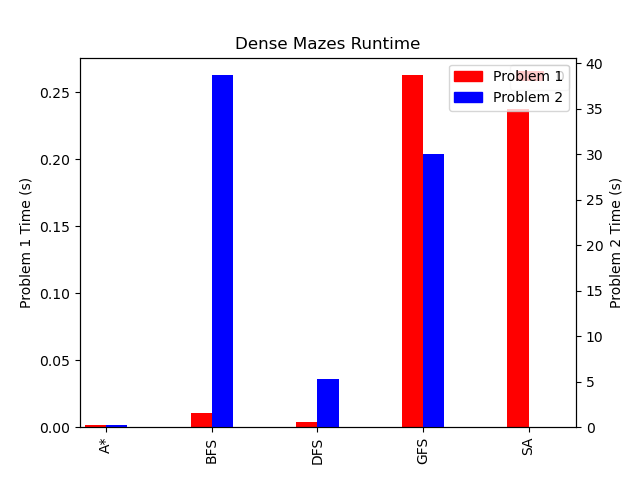

In [20]:
Image('images/dense_mazes_runtime.png')

In [ ]:
Image('images/sparse_mazes_runtime.png')

It is clear that $A^*$ is the fastest of the methods, in both models, cementing its place as the best method for this particular problem. The uninformed methods are also a little faster because they look for the goal, ending the execution as soon as it is located, although BFS explodes quickly in the more powerful model since it has a lot of nodes with the same depth and different state organization. GFS is slower, since it explores more nodes searching for ways to eat more dots not considering the goal or path cost in its calculations. It also explodes in the more powerful model. Simulated annealing is slower not because of its effectiveness in finding the goal, but because it always runs all 3000 iterations. So it is slow compared to others with the first model, and overall still fast, but also consistent and non-scaling.

## **Conclusions**

### **Models**
It is visible that different methods return better solutions for different models. Some methods are almost impractible with the more powerful model, as is the case with BFS and GFS, while others take full advantage of that version ($A^*$). DFS is a special case, that doesn't explode as much as some others, but gives some horrible solutions.

Meanwhile, the local search method with the specified value calculations does not diferentiate both models, so any of them could be used.

### **Methods**
After comparing every method, the one that performed better in terms of solution cost, time/memory requirements and failures was the $A^*$ method. This result makes sense, since an informed method with good heuristics can maximize the score more easily than other types, and using the path cost with the heuristic value guarantees that the number of steps is taken into account. For those reasons, $A*$ is often used for 2D pathfinding problems, even more than the other methods.

The best heuristic for $A^*$ was _manhattan_min_ , which is defined as the lowest manhattan distance between Pac-Man and the foods. It's a intuitive estimative that works really well in practice, a little better than _manhattan_max_ - if we were playing Pac-Man we would likely approach the nearest too. $A^*$ is great in this sense as we can try to emulate in the agent our actions as players. The idea to use not admissible heuristics proved very useful too, to balance runtime and score.  

Therefore, the overall best solution is given by the $A^*$ method, using the _manhattan_min_ heuristic in the second, most powerful model. The execution time is still very low compared to others, and on average gives better results in score. The uninformed methods were not very suitable for the task, since they do not focus on the score, which is used to measure quality. 

The local search, while in theory good for optimization problems, in practice can waste too many points in "wasted movements". The heuristic related to euclidean distance was the one to return better results with fewer failed attempts, but overall simulated annealing is an unstable method with high degree of failure for this type of problem.

### **Future Work**
As mentioned near the beginning of this report, the two models created are not the only ways to model the problem. As examples, other models could include adding the amount of dots left in the maze instead of the entire maze, keeping the maze as a problem attribute, or adding a maze/amount of dots in the goal state so that another specific task is achieved, such as eat all the dots in the maze (the goal state would be the position and an empty maze, or 0), and the list keeps going.

The goal, in this project, was used to end the execution, but it did not have a different value or had a higher priority than any dot, therefore the priority for the problem was always the score, for those methods that try to optimize it. Other ways to model the problem could include giving more importance to the goal, so methods such as GFS would search for the goal instead of more ways to increase the score (see, for example, the goal-based heuristic for GFS).

Future work could include analysing those other modeling ideas, and **check memory usage more precisely**, for an even better discussion. Online methods and genetic algorithm-based solutions could also be implemented, since they were not even touched upon in this project.

## Video
A video with examples of each method can be found here: [Link to Video](https://drive.google.com/open?id=1Jcm465ZYnpJw8roKht718mZMw7RGc0v6)